# Projects for Analysis of Anti-Depressant Drugs’s Adverse Events by FDA Adverse Event Reporting System (FAERS) from January 2019 to December 2023

## 6. TOPIC MODELLING

### 6.1 Load data

In [6]:
# Load data
import pandas as pd
data = pd.read_csv("FAERS_data_models.csv")

data['event_dt'] = pd.to_datetime(data['event_dt'])

print(data.info())
print(data.head().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108763 entries, 0 to 108762
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   primaryid      108763 non-null  int64         
 1   prod_ai        108763 non-null  object        
 2   indi_pt        108763 non-null  object        
 3   event_dt       108763 non-null  datetime64[ns]
 4   age            108763 non-null  float64       
 5   gender         108763 non-null  object        
 6   occr_country   108763 non-null  object        
 7   pt             108763 non-null  object        
 8   outc_cod       108763 non-null  object        
 9   prod_ai_group  108763 non-null  object        
 10  ae_cate        108763 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 9.1+ MB
None
                                                     0  \
primaryid                                     74189024   
prod_ai    

### 6.2 Wordcloud w/o topic modelling

In [2]:
# !pip install nltk wordcloud gensim pandas matplotlib seaborn

In [3]:
# split data into periods
pre_covid = data[data['event_dt'] < '2020-03-01']
during_covid = data[(data['event_dt'] >= '2020-03-01') & (data['event_dt'] < '2022-01-01')]
post_covid = data[data['event_dt'] >= '2022-01-01']

In [4]:
import gensim
from nltk.corpus import stopwords
import nltk
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Your suggested preprocessing function
def preprocess_text(data):
    def sent_to_words(sentences):
        for sentence in sentences:
            yield gensim.utils.simple_preprocess(str(sentence), deacc=True)  # Tokenize, lowercase, remove punctuation
    data_words = list(sent_to_words(data['pt'].values.tolist()))
    # Remove stopwords
    data_words = [[word for word in text if word not in stop_words] for text in data_words]
    return data_words

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Preprocess text for each period
pre_covid_words = preprocess_text(pre_covid)
during_covid_words = preprocess_text(during_covid)
post_covid_words = preprocess_text(post_covid)

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(data_words, title):
    # Flatten the list of lists into a single list of words
    all_words = ' '.join([' '.join(words) for words in data_words])
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=30, background_color='white').generate(all_words)
    # Display the image
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

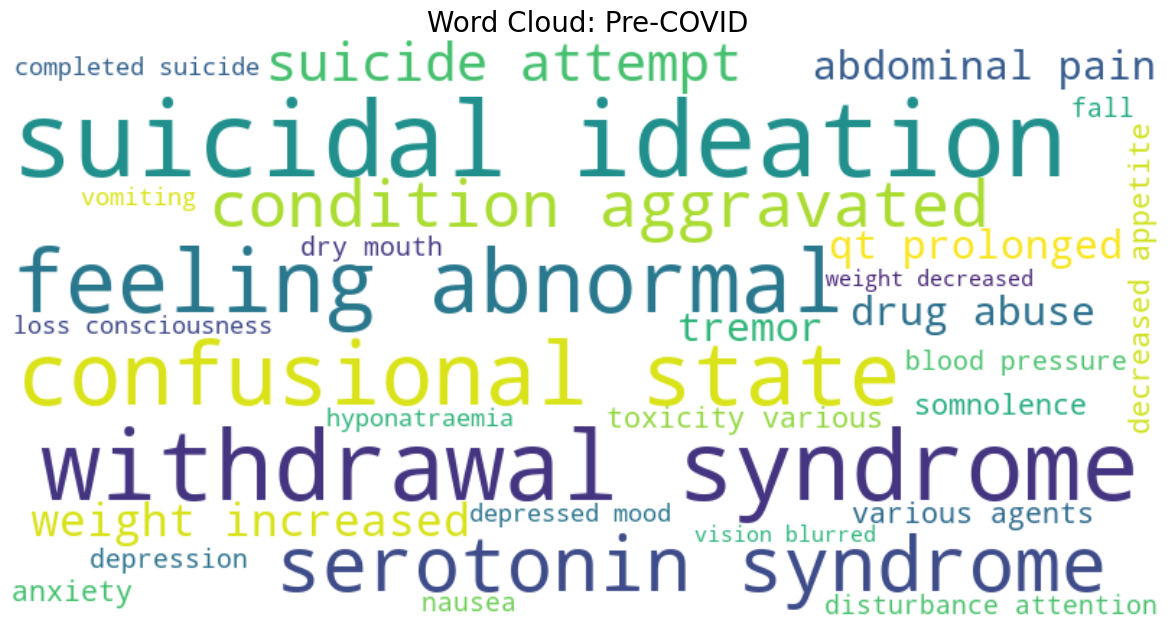

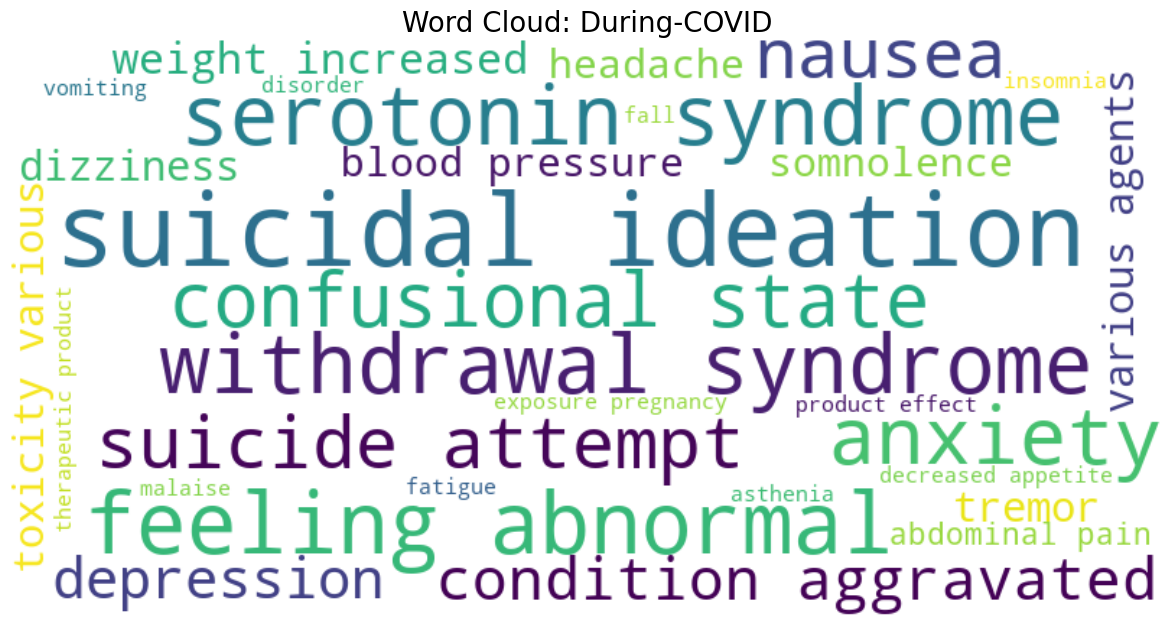

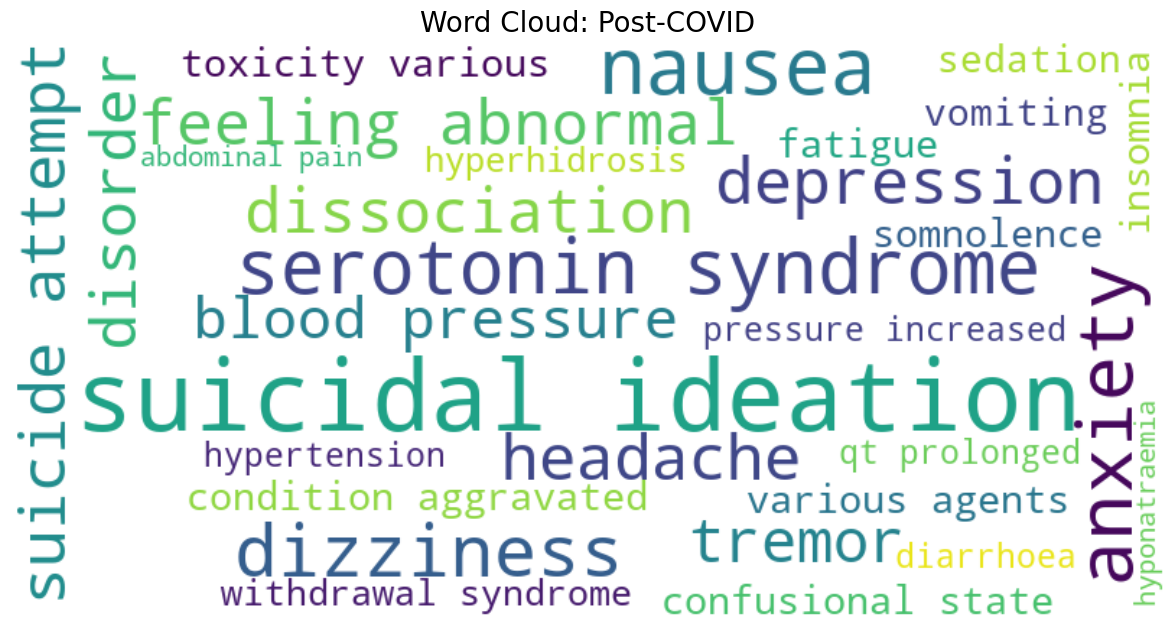

In [9]:
# Generate word clouds
generate_wordcloud(pre_covid_words, 'Word Cloud: Pre-COVID')
generate_wordcloud(during_covid_words, 'Word Cloud: During-COVID')
generate_wordcloud(post_covid_words, 'Word Cloud: Post-COVID')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to prepare data for word density plot
def prepare_word_density_data(data, data_words):
    # Add tokens back to the dataframe
    data = data.reset_index(drop=True)  # Ensure the indices align
    data['tokens'] = data_words
    # Explode tokens into individual rows
    data_exploded = data.explode('tokens')
    # Extract month from event dates
    data_exploded['month'] = data_exploded['event_dt'].dt.to_period('M').dt.to_timestamp()
    return data_exploded

# Prepare data for each period
pre_covid_exploded = prepare_word_density_data(pre_covid, pre_covid_words)
during_covid_exploded = prepare_word_density_data(during_covid, during_covid_words)
post_covid_exploded = prepare_word_density_data(post_covid, post_covid_words)

# Combine all periods
data_exploded = pd.concat([pre_covid_exploded, during_covid_exploded, post_covid_exploded])

# Calculate word counts per month
word_counts = data_exploded.groupby(['month', 'tokens']).size().reset_index(name='count')

# Select top N words for visualization (e.g., top 10)
top_n = 10
top_n_words = word_counts.groupby('tokens')['count'].sum().nlargest(top_n).index
word_counts_top = word_counts[word_counts['tokens'].isin(top_n_words)]

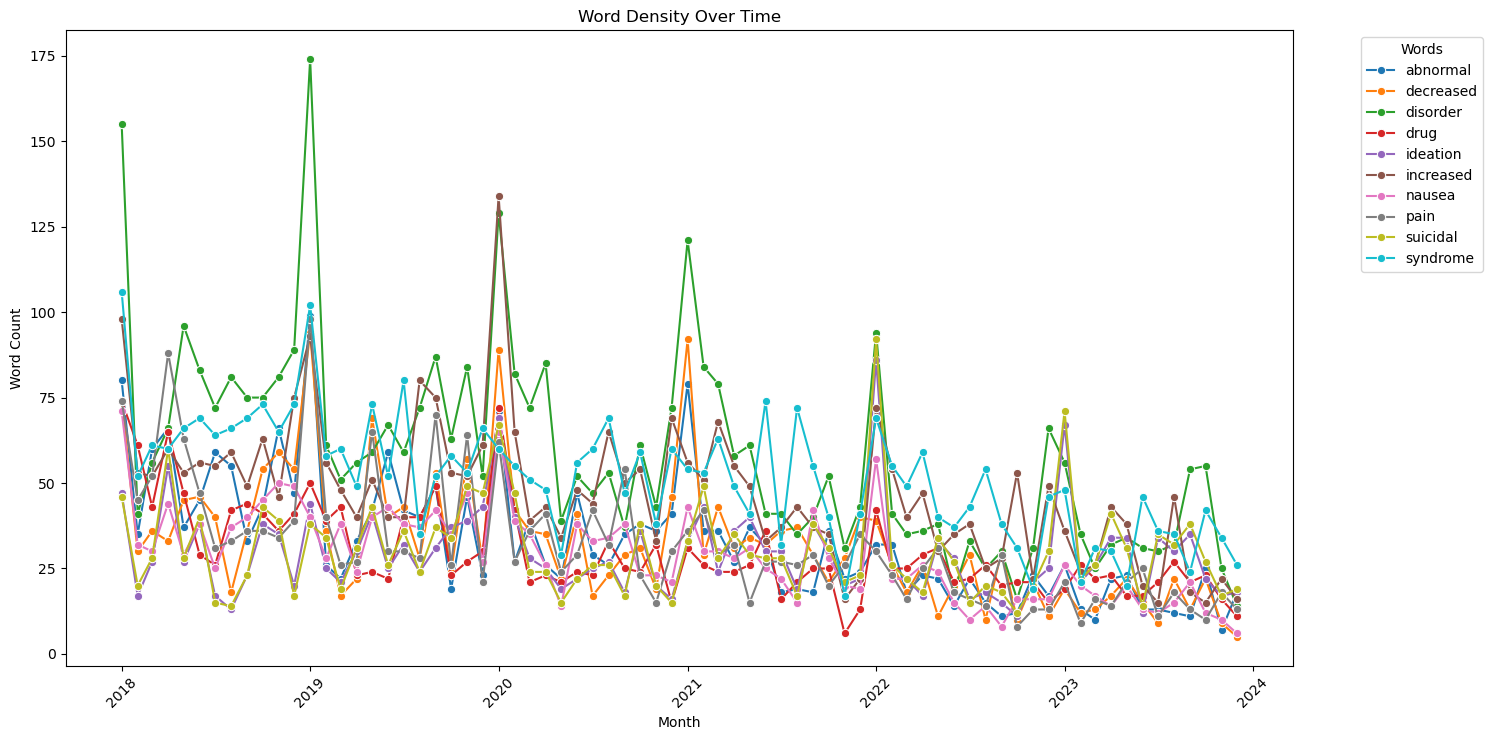

In [12]:
plt.figure(figsize=(15, 7.5))
sns.lineplot(data=word_counts_top, x='month', y='count', hue='tokens', marker='o')
plt.title('Word Density Over Time')
plt.xlabel('Month')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.legend(title='Words', bbox_to_anchor=(1.05, 1), loc=2)  # Place legend outside the plot
plt.tight_layout()
plt.show()

### 6.3 Topic Modelling with LDA

In [13]:
# !pip install pandas gensim nltk pyLDAvis matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Apply preprocessing to the entire dataset
data_words = preprocess_text(data)

# Add the tokens back to the dataframe
data['tokens'] = data_words


In [15]:
from gensim.corpora.dictionary import Dictionary

# Create a dictionary representation of the documents
dictionary = Dictionary(data['tokens'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Adjust as needed

# Create a Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

In [35]:
from gensim.models.ldamodel import LdaModel

# no of topics
num_topics = 5

# Build the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=2711,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [36]:
# Print the topics
for idx, topic in lda_model.print_topics():
    print(f'Topic {idx}: {topic}\n')

Topic 0: 0.052*"anxiety" + 0.034*"headache" + 0.024*"withdrawal" + 0.023*"vomiting" + 0.019*"qt" + 0.018*"mood" + 0.018*"haemorrhage" + 0.018*"prolonged" + 0.017*"state" + 0.016*"diarrhoea"

Topic 1: 0.090*"pain" + 0.080*"drug" + 0.050*"fatigue" + 0.045*"suicide" + 0.036*"abdominal" + 0.031*"attempt" + 0.030*"condition" + 0.028*"aggravated" + 0.026*"impairment" + 0.024*"hallucination"

Topic 2: 0.132*"syndrome" + 0.082*"depression" + 0.076*"insomnia" + 0.047*"tremor" + 0.040*"serotonin" + 0.034*"malaise" + 0.030*"panic" + 0.030*"muscle" + 0.026*"attack" + 0.019*"pulmonary"

Topic 3: 0.104*"disorder" + 0.071*"nausea" + 0.058*"suicidal" + 0.056*"ideation" + 0.037*"injury" + 0.028*"discomfort" + 0.026*"disturbance" + 0.025*"toxicity" + 0.024*"agents" + 0.024*"various"

Topic 4: 0.091*"increased" + 0.090*"abnormal" + 0.071*"decreased" + 0.066*"dizziness" + 0.062*"feeling" + 0.040*"weight" + 0.035*"paraesthesia" + 0.029*"appetite" + 0.029*"blood" + 0.021*"seizure"



In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_topic_wordcloud(model, topic_num):
    plt.figure(figsize=(15, 7.5))
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {topic_num}', fontsize=20)
    topic_terms = dict(model.show_topic(topic_num, topn=30))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_terms)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

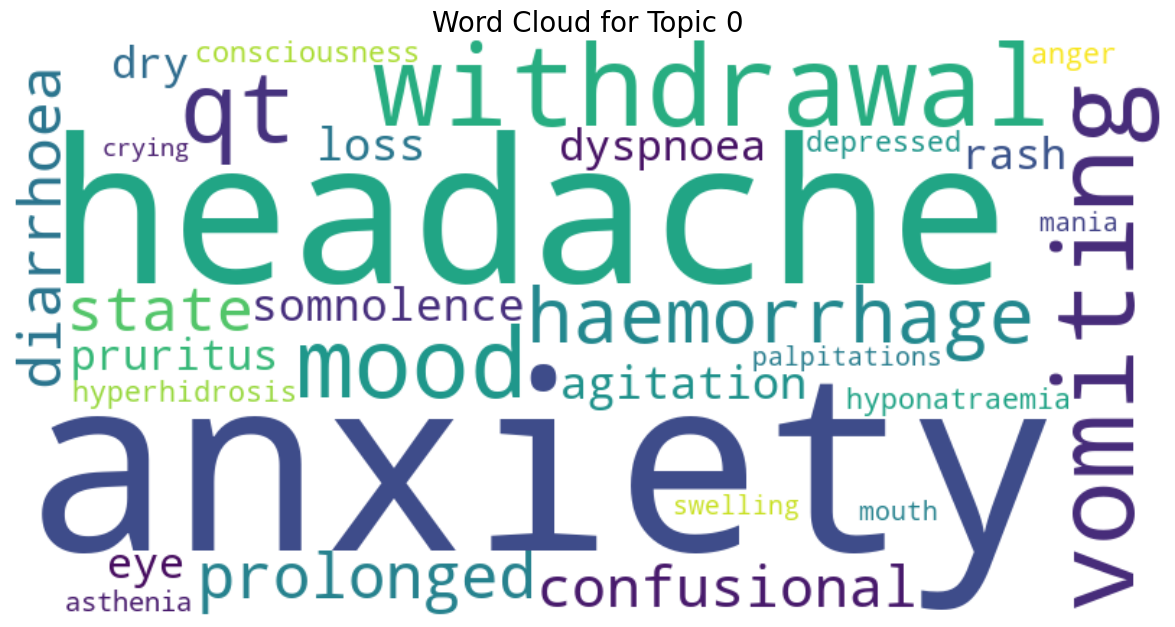

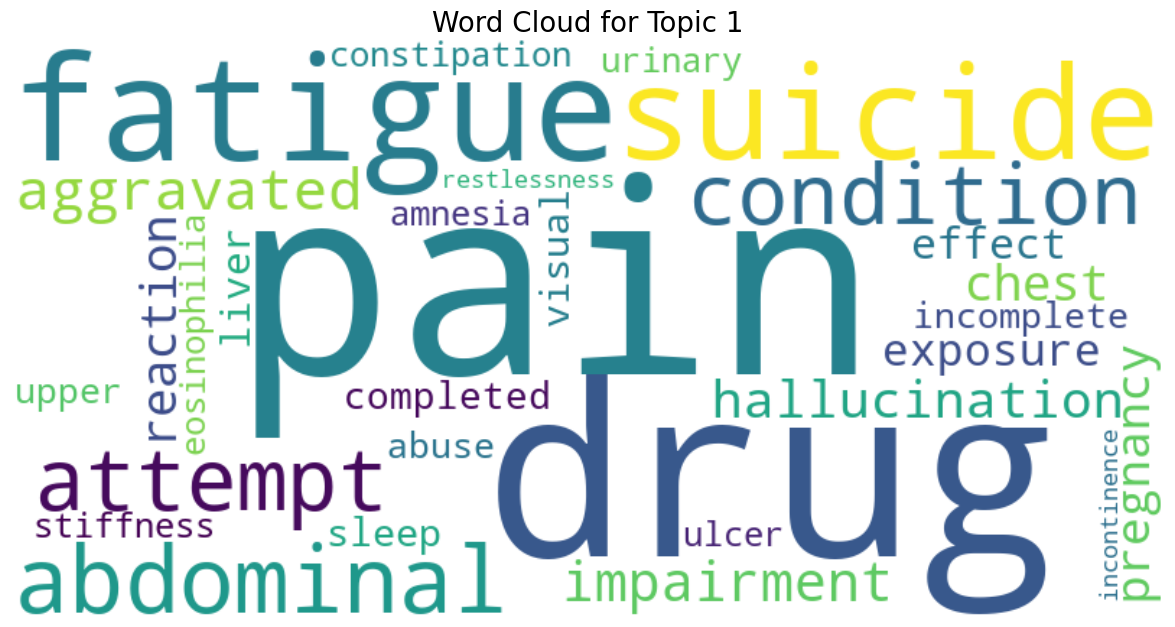

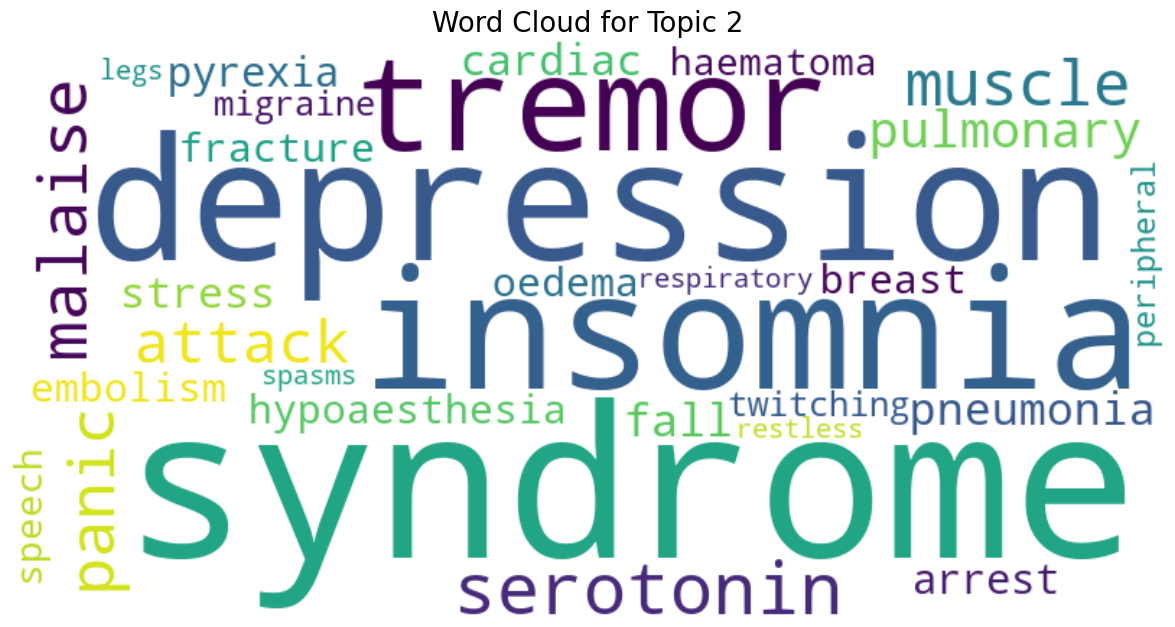

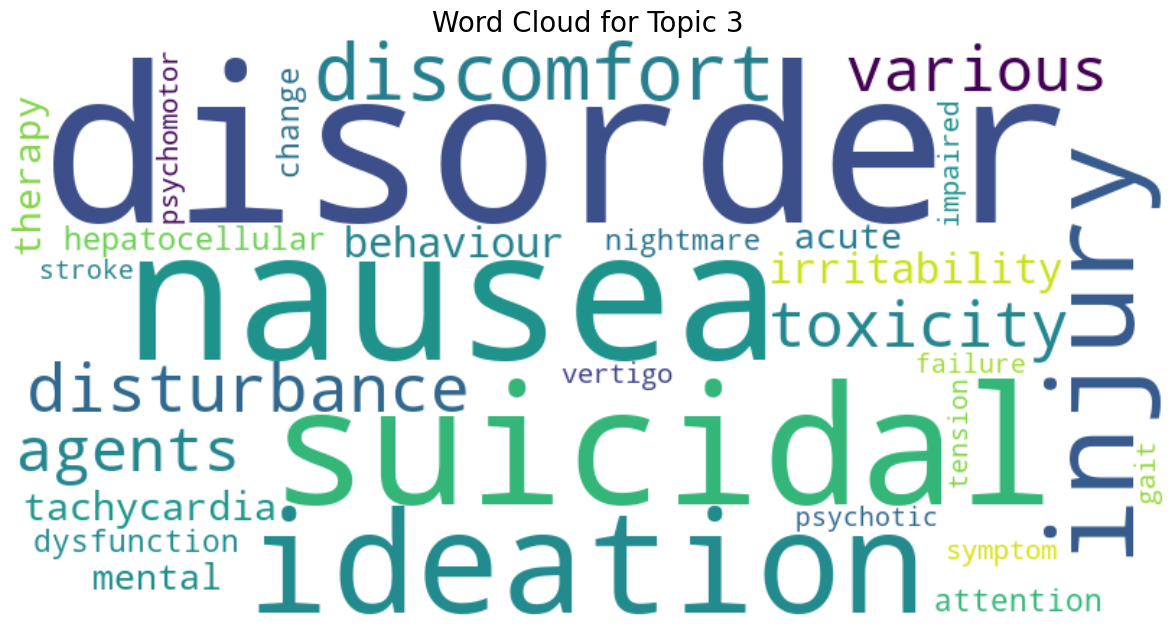

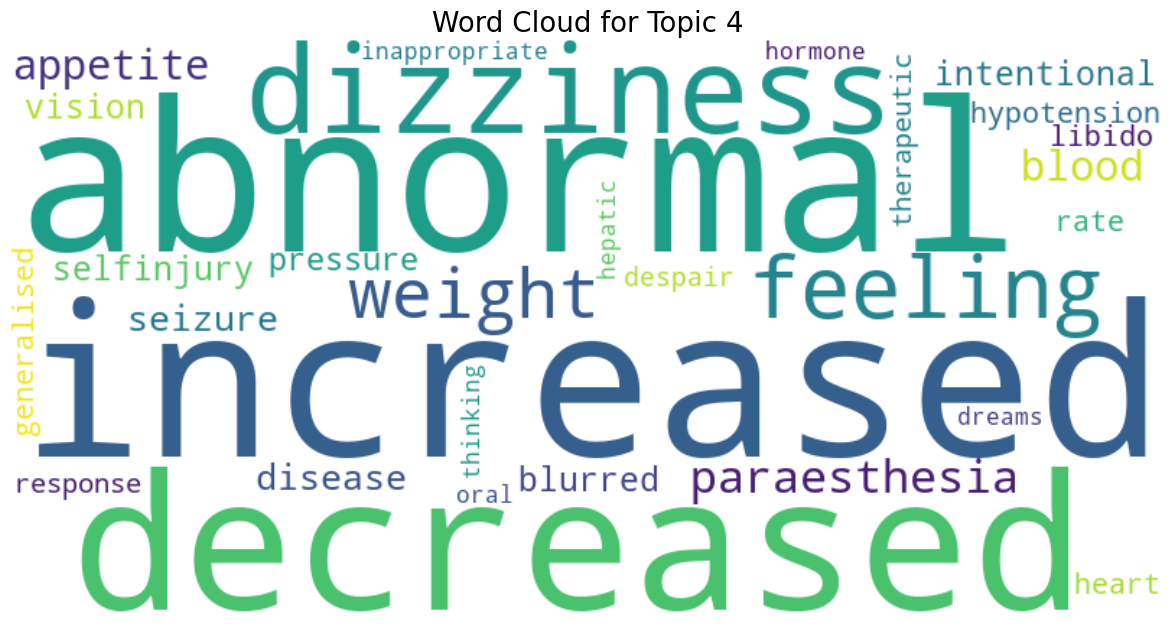

In [38]:
# Generate word clouds for each topic
for topic_num in range(num_topics):
    generate_topic_wordcloud(lda_model, topic_num)

In [39]:
def get_dominant_topic(ldamodel, corpus):
    dominant_topics = []
    topic_percentages = []
    for doc_topics in ldamodel.get_document_topics(corpus):
        sorted_doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
        dominant_topic = sorted_doc_topics[0][0]
        topic_percentage = sorted_doc_topics[0][1]
        dominant_topics.append(dominant_topic)
        topic_percentages.append(topic_percentage)
    return dominant_topics, topic_percentages

In [40]:
# Get dominant topics and their percentages
dominant_topics, topic_percentages = get_dominant_topic(lda_model, corpus)

# Add to the dataframe
data['dominant_topic'] = dominant_topics
data['topic_percentage'] = topic_percentages

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

# Convert event dates to monthly periods
data['month'] = data['event_dt'].dt.to_period('M').dt.to_timestamp()

# Calculate topic counts per month
topic_counts = data.groupby(['month', 'dominant_topic']).size().reset_index(name='count')

# Calculate total documents per month
monthly_totals = data.groupby('month').size().reset_index(name='total_count')

# Merge and calculate topic densities
topic_counts = topic_counts.merge(monthly_totals, on='month')
topic_counts['topic_density'] = topic_counts['count'] / topic_counts['total_count']

# Prepare data for LOESS smoothing
topic_counts['month_ordinal'] = topic_counts['month'].map(pd.Timestamp.toordinal)

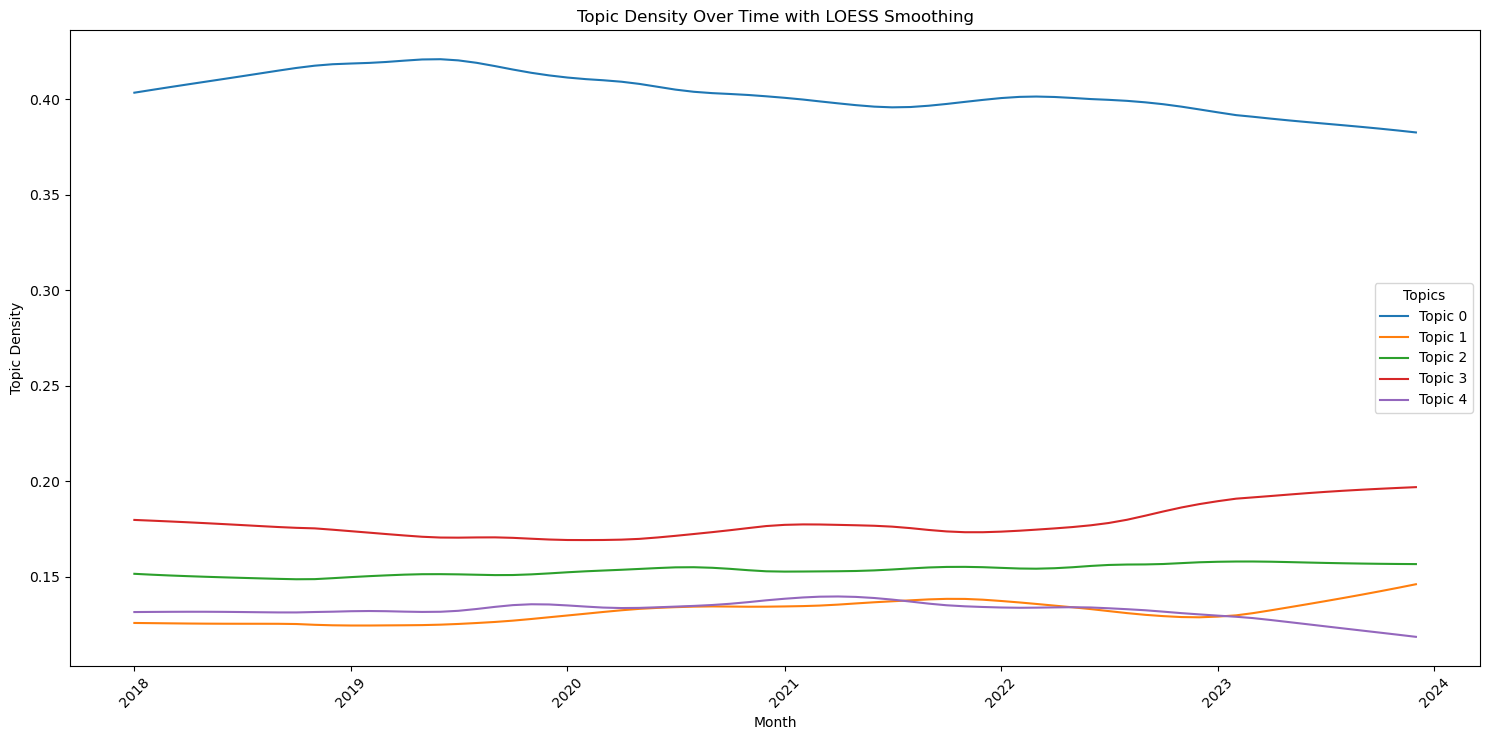

In [42]:
# Plot Topic Density Over Time with LOESS Smoothing
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate the original ordinals of the months
topic_counts['month_ordinal'] = topic_counts['month'].map(pd.Timestamp.toordinal)

# Reference date ordinal for '1970-01-01'
ref_date_ordinal = pd.Timestamp('1970-01-01').toordinal()

# Adjust ordinals to represent days since '1970-01-01'
topic_counts['month_ordinal_adj'] = topic_counts['month_ordinal'] - ref_date_ordinal

# Plot topic density over time with LOESS smoothing
plt.figure(figsize=(15, 7.5))

for topic_num in topic_counts['dominant_topic'].unique():
    topic_data = topic_counts[topic_counts['dominant_topic'] == topic_num]

    # Apply LOESS smoothing using adjusted ordinals
    smoothed = lowess(
        topic_data['topic_density'],
        topic_data['month_ordinal_adj'],
        frac=0.3
    )

    # Convert adjusted ordinals back to datetime
    smoothed_dates = pd.to_datetime(smoothed[:, 0], unit='D', origin='1970-01-01')

    # Plot the smoothed data
    plt.plot(
        smoothed_dates,
        smoothed[:, 1],
        label=f'Topic {topic_num}'
    )

plt.title('Topic Density Over Time with LOESS Smoothing')
plt.xlabel('Month')
plt.ylabel('Topic Density')
plt.xticks(rotation=45)
plt.legend(title='Topics')
plt.tight_layout()
plt.show()


In [43]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Or save to HTML file
pyLDAvis.save_html(vis_data, 'lda_topics.html')

> Refer fda_step7_stat for PRR and ROR analysis.